In [1]:
import requests
import os
from PIL import Image
import numpy as np
import cntk as C
from cntk.io import MinibatchSource, CTFDeserializer, StreamDef, StreamDefs

In [2]:
from __future__ import print_function
try: 
    from urllib.request import urlretrieve 
except ImportError: 
    from urllib import urlretrieve
import sys
import gzip
import shutil
import os
import struct
import numpy as np

def loadData(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x3080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))[0]
            if n != cimg:
                raise Exception('Invalid file: expected {0} entries.'.format(cimg))
            crow = struct.unpack('>I', gz.read(4))[0]
            ccol = struct.unpack('>I', gz.read(4))[0]
            if crow != 28 or ccol != 28:
                raise Exception('Invalid file: expected 28 rows/cols per image.')
            # Read data.
            res = np.fromstring(gz.read(cimg * crow * ccol), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, crow * ccol))

def loadLabels(src, cimg):
    print ('Downloading ' + src)
    gzfname, h = urlretrieve(src, './delete.me')
    print ('Done.')
    try:
        with gzip.open(gzfname) as gz:
            n = struct.unpack('I', gz.read(4))
            # Read magic number.
            if n[0] != 0x1080000:
                raise Exception('Invalid file: unexpected magic number.')
            # Read number of entries.
            n = struct.unpack('>I', gz.read(4))
            if n[0] != cimg:
                raise Exception('Invalid file: expected {0} rows.'.format(cimg))
            # Read labels.
            res = np.fromstring(gz.read(cimg), dtype = np.uint8)
    finally:
        os.remove(gzfname)
    return res.reshape((cimg, 1))

def load(dataSrc, labelsSrc, cimg):
    data = loadData(dataSrc, cimg)
    labels = loadLabels(labelsSrc, cimg)
    return np.hstack((data, labels))

def savetxt(filename, ndarray):
    with open(filename, 'w') as f:
        labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
        for row in ndarray:
            row_str = row.astype(str)
            label_str = labels[row[-1]]
            feature_str = ' '.join(row_str[:-1])
            f.write('|labels {} |features {}\n'.format(label_str, feature_str))


In [3]:
from __future__ import print_function
import os
import mnist_utils as ut

os.chdir(os.path.abspath(os.path.dirname("./")))
train = ut.load('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 60000)
print ('Writing train text file...')
ut.savetxt(r'./Train-28x28_cntk_text.txt', train)
print ('Done.')
test = ut.load('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz',
    'http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 10000)
print ('Writing test text file...')
ut.savetxt(r'./Test-28x28_cntk_text.txt', test)
print ('Done.')

ModuleNotFoundError: No module named 'mnist_utils'

In [4]:
def create_reader(path, is_training, input_dim, num_label_classes):
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    
    deserailizer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels = labelStream, features = featureStream))
            
    return C.io.MinibatchSource(deserailizer,
       randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

In [5]:
input_dim = 784
num_output_classes = 10

input = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

In [6]:
def create_model(features):
    with C.layers.default_options(init = C.glorot_uniform()):
        r = C.layers.Dense(num_output_classes, activation = None)(features)
        return r

In [7]:
input_s = input/255
z = create_model(input_s)

In [8]:
loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)

In [9]:
# Instantiate the trainer object to drive the model training
learning_rate = 0.2
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

In [10]:
# Initialize the parameters for the trainer
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [11]:
# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose: 
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
        
    return mb, training_loss, eval_error

In [12]:
reader_train = create_reader("./Train-28x28_cntk_text.txt", True, input_dim, num_output_classes)

# Map the data streams to the input and labels.
input_map = {
    label  : reader_train.streams.labels,
    input  : reader_train.streams.features
} 

# Run the trainer on and perform model training
training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    # Read a mini batch from the training data file
    data = reader_train.next_minibatch(minibatch_size, input_map = input_map)
    
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.2905, Error: 89.06%
Minibatch: 500, Loss: 0.5157, Error: 9.38%
Minibatch: 1000, Loss: 0.2309, Error: 6.25%
Minibatch: 1500, Loss: 0.4488, Error: 15.62%
Minibatch: 2000, Loss: 0.1886, Error: 6.25%
Minibatch: 2500, Loss: 0.1871, Error: 7.81%
Minibatch: 3000, Loss: 0.1088, Error: 1.56%
Minibatch: 3500, Loss: 0.3145, Error: 10.94%
Minibatch: 4000, Loss: 0.3526, Error: 10.94%
Minibatch: 4500, Loss: 0.2487, Error: 4.69%
Minibatch: 5000, Loss: 0.2001, Error: 3.12%
Minibatch: 5500, Loss: 0.1292, Error: 3.12%
Minibatch: 6000, Loss: 0.1509, Error: 3.12%
Minibatch: 6500, Loss: 0.2773, Error: 9.38%
Minibatch: 7000, Loss: 0.1736, Error: 6.25%
Minibatch: 7500, Loss: 0.3076, Error: 7.81%
Minibatch: 8000, Loss: 0.1197, Error: 3.12%
Minibatch: 8500, Loss: 0.1455, Error: 3.12%
Minibatch: 9000, Loss: 0.1129, Error: 3.12%


Text(0.5,1,'Minibatch run vs. Training loss')

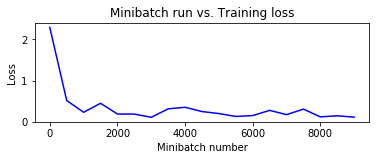

In [13]:
# Plot the training loss and the training error
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["loss"], 'b')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

In [14]:
z.save("./mnist_model")